In [1]:
#!pip install imblearn
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pymongo import MongoClient
import pandas as pd

import numpy as np
from scipy import interp
from scipy.stats import ttest_1samp, wilcoxon, mannwhitneyu

import matplotlib.pyplot as plt
from itertools import cycle
import urllib.parse

from sklearn.externals import joblib 
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.utils.fixes import signature

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids, NearMiss
from imblearn.metrics import classification_report_imbalanced

In [3]:
MONGODB_HOST = pd.read_csv('./database/auth')['host'][0]
username = urllib.parse.quote_plus(pd.read_csv('./database/auth')['username'][0])
password = urllib.parse.quote_plus(pd.read_csv('./database/auth')['password'][0])
conn = MongoClient('mongodb://%s:%s@%s' % (username, password, MONGODB_HOST))
#conn.database_names()
conn.database_names()

['1071_Common_English',
 'AU',
 'CYCU_1031SP',
 'CYCU_1032OS',
 'CYCU_1041SP',
 'CYCU_1042OS',
 'CYCU_1051SP',
 'CYCU_1052OS',
 'KU',
 'KU_dataset_1',
 'KU_dataset_2',
 'KyoU',
 'NCU_1071MATH',
 'NCU_CHKA',
 'NCU_CHKB',
 'NCU_CL',
 'NCU_ETS',
 'NCU_FC',
 'NCUx107_Pre_college_calculas',
 'OULAD',
 'Warn',
 'admin',
 'config',
 'local']

In [4]:
datasets = 'NCU_CL'
db = conn[datasets]
collection = db['NCU_107_1_CL_control_grade']
score_df = pd.DataFrame(list(collection.find()))
#score_df = score_df.drop(['_id'], axis=1)
score_df = score_df[['midterm_score', 'Userid']]
#score_df = score_df.dropna()
#score_df = score_df['midterm_score'].astype(float)

up_bound = 100
low_bound = 50
score_df['mid_score'] = low_bound + (score_df['midterm_score']-score_df['midterm_score'].min())*(up_bound-low_bound)/(score_df['midterm_score'].max()-score_df['midterm_score'].min())
# score_df['mid_score'] = score_df['midterm_score']

score_df = score_df.drop(['midterm_score'], axis=1)
score_df['mid_score'].std()

16.950423293146688

In [5]:
db = conn[datasets]
collection = db['NCU_107_1_w1-9_CL']
feature_df = pd.DataFrame(list(collection.find()))
feature_df = feature_df.drop(['_id'], axis=1)

#feature_df = feature_df.fillna('0')
#feature_df.rename(index=str, columns={"Userid": "userid"}, inplace=True)
#feature_df = df['final_score']
#feature_df = score_df.dropna()
#feature_df = feature_df.astype(float)

#feature_df = feature_df.groupby(['username']).mean()
feature_df.head(5)

,Add_Bookmark,Add_Marker,Add_Memo,Change_Memo,Close,Delete_Bookmark,Delete_Marker,Delete_Memo,Jump,Marker,Memo,Next,Open,Prev,Search,Userid
0,0,65,0,0,17,0,2,0,0,67,0,302,20,15,0,brstudent05
1,15,87,36,17,14,0,2,0,37,89,53,967,62,371,0,brstudent09
2,15,36,11,6,54,1,4,1,60,40,18,1790,97,796,0,brstudent10
3,12,20,171,132,59,5,7,8,8,27,311,2072,112,817,4,brstudent11
4,2,6,17,17,33,2,2,4,2,8,38,1944,82,1291,1,brstudent12


In [6]:
ncu_ets = pd.merge(feature_df, score_df, on='Userid')
ncu_ets = ncu_ets.drop(['Userid'], axis=1)
#ncu_ets = ncu_ets.drop(['week'], axis=1)
ncu_ets = ncu_ets.astype(float)
ncu_ets['class'] = ncu_ets['mid_score'] < 60
ncu_ets = ncu_ets.drop(['mid_score'], axis=1)
ncu_ets

,Add_Bookmark,Add_Marker,Add_Memo,Change_Memo,Close,Delete_Bookmark,Delete_Marker,Delete_Memo,Jump,Marker,Memo,Next,Open,Prev,Search,class
0,0.0,65.0,0.0,0.0,17.0,0.0,2.0,0.0,0.0,67.0,0.0,302.0,20.0,15.0,0.0,True
1,15.0,87.0,36.0,17.0,14.0,0.0,2.0,0.0,37.0,89.0,53.0,967.0,62.0,371.0,0.0,False
2,15.0,36.0,11.0,6.0,54.0,1.0,4.0,1.0,60.0,40.0,18.0,1790.0,97.0,796.0,0.0,False
3,12.0,20.0,171.0,132.0,59.0,5.0,7.0,8.0,8.0,27.0,311.0,2072.0,112.0,817.0,4.0,False
4,2.0,6.0,17.0,17.0,33.0,2.0,2.0,4.0,2.0,8.0,38.0,1944.0,82.0,1291.0,1.0,False
5,38.0,88.0,10.0,2.0,19.0,1.0,13.0,0.0,2.0,101.0,12.0,362.0,28.0,88.0,0.0,True
6,27.0,30.0,20.0,5.0,15.0,2.0,9.0,0.0,7.0,39.0,25.0,430.0,24.0,124.0,0.0,False
7,27.0,108.0,21.0,10.0,26.0,0.0,1.0,0.0,3.0,109.0,31.0,608.0,38.0,133.0,0.0,False
8,4.0,38.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,43.0,0.0,66.0,4.0,8.0,1.0,True
9,63.0,91.0,12.0,0.0,8.0,1.0,2.0,0.0,0.0,93.0,12.0,258.0,12.0,26.0,0.0,False


In [7]:
X = ncu_ets.drop(['class'], axis=1)
X = X.values
y = ncu_ets['class']

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)

clf_binary = svm.SVC(kernel='linear', 
                     probability=True,
                     cache_size=70,
                     random_state=5)

clf_one = svm.OneClassSVM(kernel="rbf",
                         cache_size=700,
                        random_state=5)

In [8]:
def compute_roc (X, y, title):
    
    tprs = []
    aucs = []
    #acc = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    pred_list = []
    
    i = 0
    for train, test in cv.split(X, y):

        y_pred = clf_binary.fit(X[train], y[train]).predict_proba(X[test])
        
        # Save Model
        model_name = 'models/' + datasets + '_' + str(title) + '_' + str(i) + '.pkl'
        joblib.dump(clf_binary, model_name)
        
        # Create Predict Matrix
        temp_df = pd.DataFrame({title: y_pred[:, 1].round()},
                               index=test)
        pred_list.append(temp_df)
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], y_pred[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        acc = accuracy_score(y[test], y_pred[:, 1].round())
        precision, recall, _ = precision_recall_curve(y[test], y_pred[:, 1])
        average_precision = average_precision_score(y[test], y_pred[:, 1])
        #accs.append(accuracy_score(y[test], y_pred[:, 1].round()))
        ax1.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f, ACC = %0.2f)' % (i, roc_auc, acc))

        i += 1

    pred_pd = pd.concat(pred_list)
    
    # Plot
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver operating characteristic of '+ title)
    ax1.legend(loc="lower right")
    
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    ax2.step(recall, precision, color='b', alpha=0.2, where='post')
    ax2.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    ax2.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    image_name = './images/' + datasets + '_' + title + '.png'
    fig.savefig(image_name, dpi=300)
    
    return aucs, pred_pd

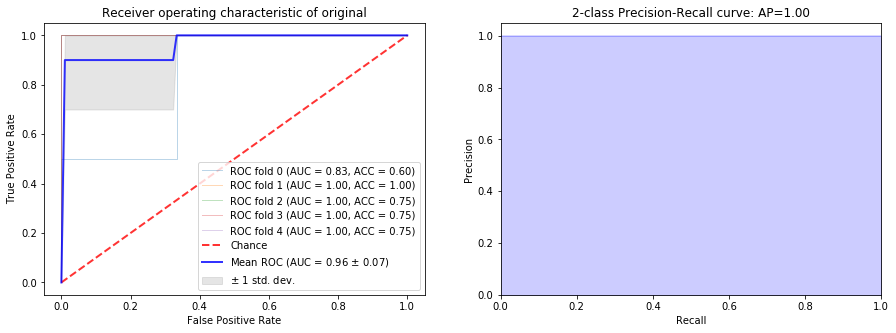

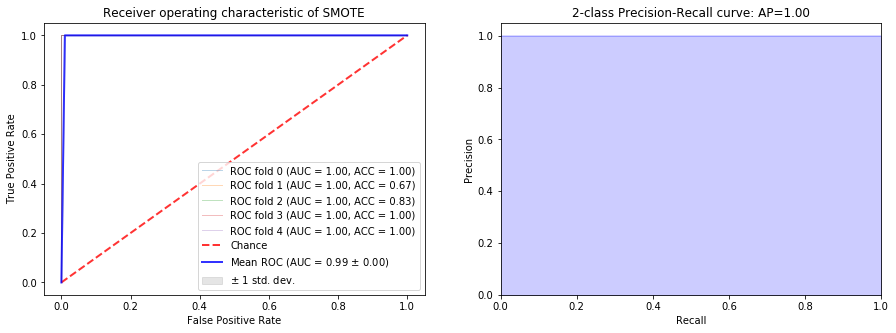

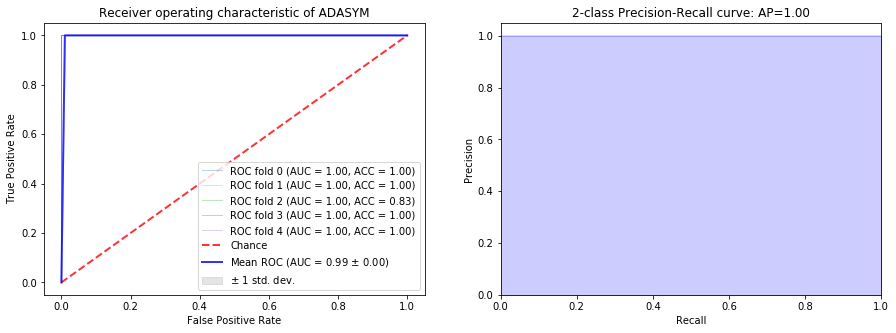

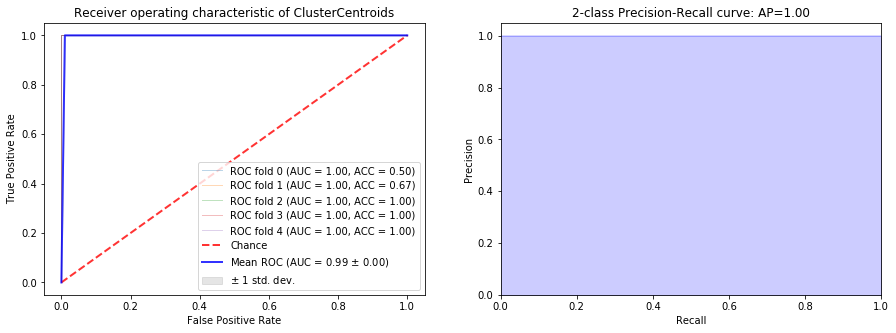

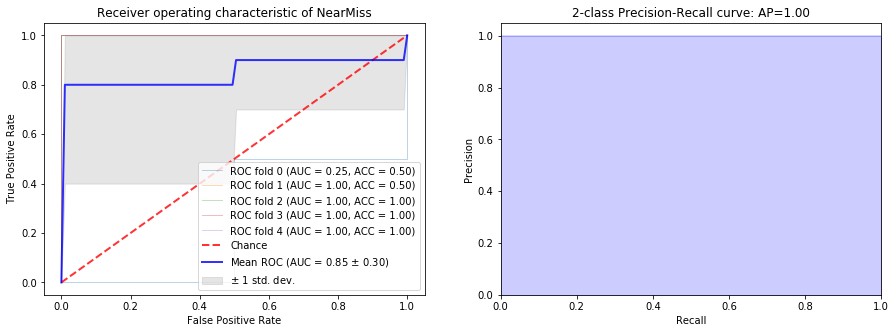

In [9]:
auc_ori, pred_pd_ori = compute_roc(X, y, title='original')

res_X, res_y = SMOTE(ratio = 1.0, k_neighbors=3).fit_sample(X, y)
auc_sm, pred_pd_sm = compute_roc(res_X, res_y, title='SMOTE')

res_X, res_y = ADASYN(ratio = 1.0, n_neighbors=3).fit_sample(X, y)
auc_ada, pred_pd_ada = compute_roc(res_X, res_y, title='ADASYM')

res_X, res_y = ClusterCentroids(random_state=0, ratio = 0.8).fit_sample(X, y)
auc_cc, _ = compute_roc(res_X, res_y, title='ClusterCentroids')

res_X, res_y = NearMiss(random_state=0).fit_sample(X, y)
auc_nm, _ = compute_roc(res_X, res_y, title='NearMiss')

In [10]:
u, p_value = mannwhitneyu(auc_ori, auc_sm)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_ada)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_cc, use_continuity=False)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_nm)
print ("two-sample wilcoxon-test", p_value)

two-sample wilcoxon-test 0.2118553985833967
two-sample wilcoxon-test 0.2118553985833967
two-sample wilcoxon-test 0.15865525393145707
two-sample wilcoxon-test 0.5


# Engagement

In [11]:
temp_pd = ncu_ets
temp_pd['original'] = pred_pd_ori
temp_pd['smote'] = pred_pd_sm
# temp_pd['adasyn'] = pred_pd_ada

best_resampler = 'smote'

In [12]:
#risk
T1 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0)])
T2 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 1.0)])
T3 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd[best_resampler] == 0.0)])
T4 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd[best_resampler] == 1.0)])
#non-risk
T5 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0)])
T6 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 1.0)])
T7 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd[best_resampler] == 0.0)])
T8 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd[best_resampler] == 1.0)])

print(' Risk:', T1, T2, 
      '\n Risk(after resample):', T3, T4,
      '\n Non-Risk:', T5, T6, 
      '\n Non-Risk(after resample):',T7, T8)

 Risk: 5 1 
 Risk(after resample): 0 6 
 Non-Risk: 15 0 
 Non-Risk(after resample): 12 3


In [13]:
origin_pd_t5 = temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 1.0)]
smote_pd_t6 = temp_pd.ix[(temp_pd['class']==False) & (temp_pd[best_resampler] == 1.0)]
origin_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0)]
smote_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd[best_resampler] == 0.0)]

# origin_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]
# smote_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]
# origin_pd_t5 = temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]
# smote_pd_t6 = temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]

<Figure size 1080x1080 with 0 Axes>

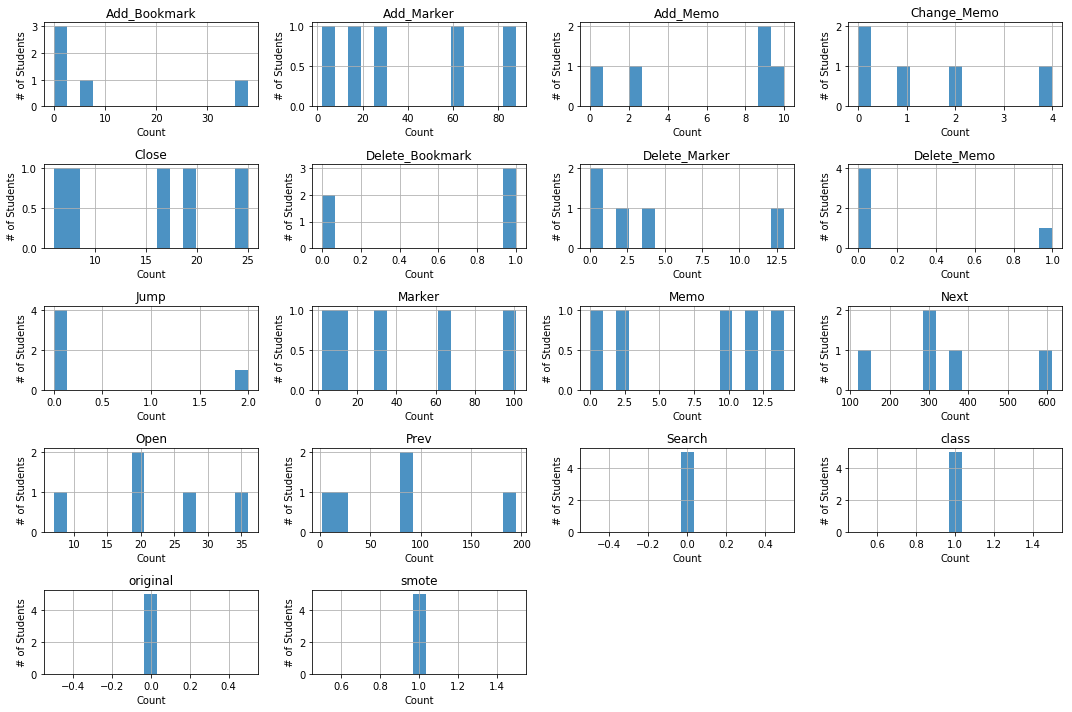

In [14]:
plt.figure(figsize=(15, 15))
ax = origin_pd.hist(alpha=0.8, bins=15, figsize=(15, 10))

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel('Count')

plt.tight_layout()
image_name = './images/' + datasets + '_' + 'fc_original' + '.png'
plt.savefig(image_name, dpi=300)

<Figure size 1080x1080 with 0 Axes>

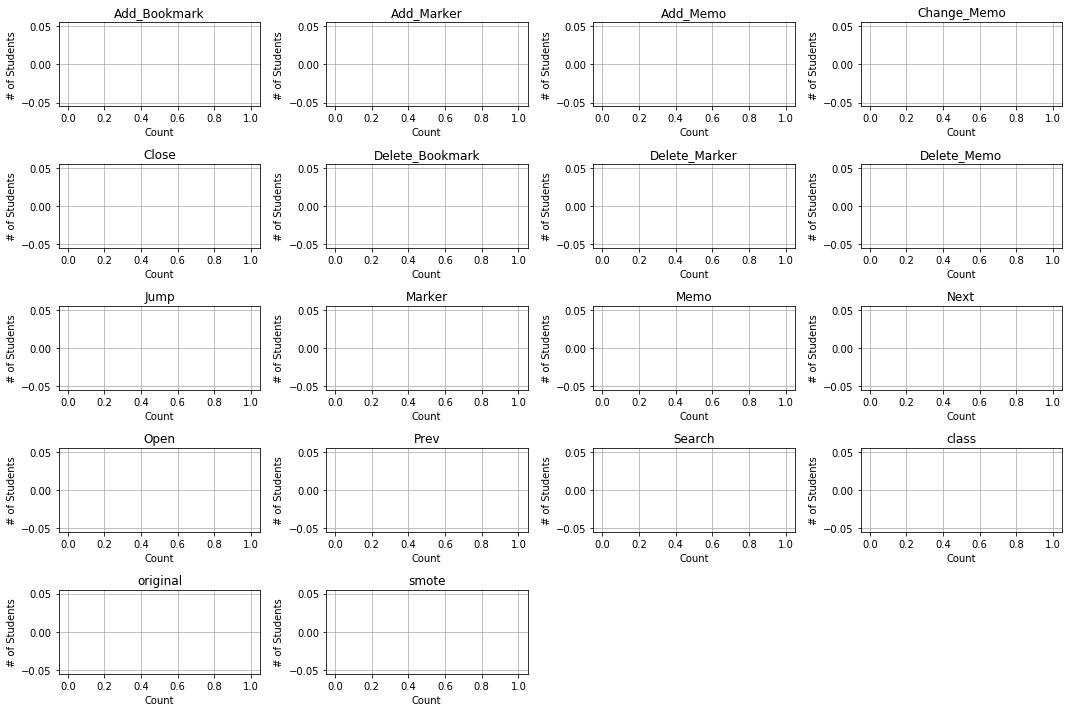

In [15]:
plt.figure(figsize=(15, 15))
ax = smote_pd.hist(alpha=0.8, bins=15, figsize=(15, 10))

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel('Count')

plt.tight_layout()
image_name = './images/' + datasets + '_' + 'fc_smote' + '.png'
plt.savefig(image_name, dpi=300)

IndexError: list index out of range

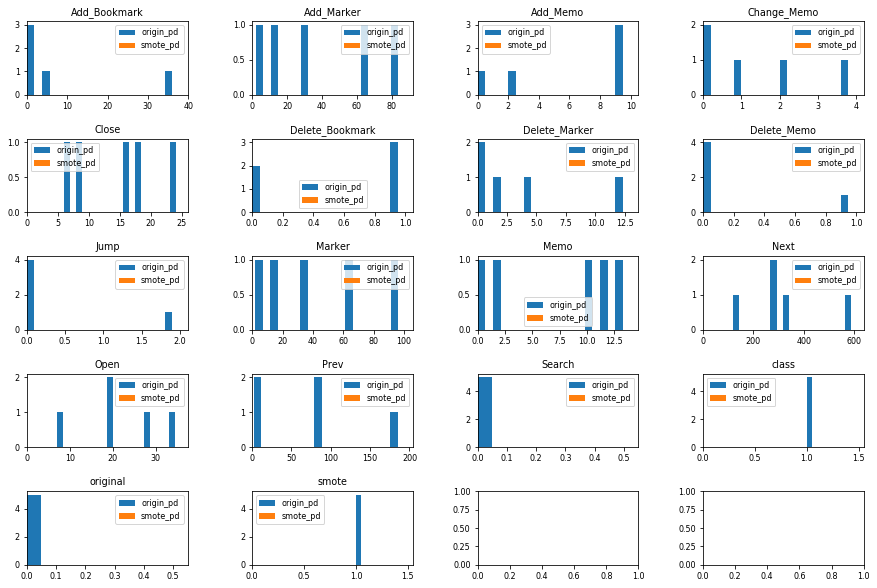

In [16]:
plt.rcParams.update({'font.size': 8})
titles = list(origin_pd)

fig, axes = plt.subplots(5,4, figsize=(15, 10))
plt.subplots_adjust(hspace=0.6, wspace=0.4)
bins=10
a = axes.ravel()
for idx,ax in enumerate(a):
    ax.hist([origin_pd[list(origin_pd)[idx]].values, 
            smote_pd[list(smote_pd)[idx]].values],
            label=['origin_pd','smote_pd'],
            bins=bins,
            rwidth=10.0)

    ax.legend()
    ax.set_title(titles[idx])
    #ax.set_xlabel(xaxes[idx])
    #ax.set_ylabel(yaxes[idx])
    ax.set_xlim(left=0)
    #plt.legend()

plt.tight_layout()
image_name = './images/' + datasets + '_' + 'smote_identified' + '.png'
plt.savefig(image_name, dpi=300)

In [ ]:
plt.rcParams.update({'font.size': 8})
titles = list(origin_pd)

fig, axes = plt.subplots(5,4, figsize=(15, 10))
plt.subplots_adjust(hspace=0.6, wspace=0.4)
bins=10
a = axes.ravel()
for idx,ax in enumerate(a):
    ax.hist([origin_pd_t5[list(origin_pd_t5)[idx]].values,
            smote_pd_t6[list(smote_pd_t6)[idx]].values],
            label=['origin_pd','smote_pd'],
            bins=bins,
            rwidth=10.0)

    ax.legend()
    ax.set_title(titles[idx])
    #ax.set_xlabel(xaxes[idx])
    #ax.set_ylabel(yaxes[idx])
    ax.set_xlim(left=0)
    #plt.legend()

#plt.tight_layout()

image_name = './images/' + datasets + '_' + 'smote_misidentified' + '.png'
plt.savefig(image_name, dpi=300)

In [ ]:
plt.rcParams.update({'font.size': 16})

origin_pd_t5 = temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 1.0)]
smote_pd_t6 = temp_pd.ix[(temp_pd['class']==False) & (temp_pd['smote'] == 1.0)]
origin_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0)]
smote_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['smote'] == 0.0)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bins=10

ax[0].hist([origin_pd[list(origin_pd)[0]].values,
            smote_pd[list(smote_pd)[0]].values],
            label=['Type1:misidentified', 'Type2:misidentified, but \nidentified after resample'],
            bins=bins,
            rwidth=10.0)

ax[0].legend()
ax[0].set_xlabel('Number of Activites')
ax[0].set_ylabel('Number of Recoards')
ax[0].set_title('Risk Population')
ax[0].set_xlim(left=0)

ax[1].hist([origin_pd_t5[list(origin_pd_t5)[2]].values,
            smote_pd_t6[list(smote_pd_t6)[2]].values],
            label=['Type5:identified', 'Type6:identified, but \nmisidentified after resample'],
            bins=bins,
            rwidth=10.0)

ax[1].legend()
ax[1].set_xlabel('Number of Activites')
ax[1].set_ylabel('Number of Recoards')
ax[1].set_title('non-Risk Population')
ax[1].set_xlim(left=0)

plt.tight_layout()
image_name = './images/' + datasets + '_' + list(origin_pd)[2] + '.png'
plt.savefig(image_name, dpi=300)

# Confusion Metrix

In [ ]:
plt.rcParams.update({'font.size': 16})

vegetables = ["Identified",
              "Mis-identified"]
farmers = ["Risk", "Non-Risk"]


In [ ]:
harvest = np.array([[T2, T5],
                    [T1, T6]])

#plt.style.use('classic')
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(harvest, cmap=plt.cm.BuGn)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        if (harvest[i, j]) > 30: 
            color='white'
        else:
            color='black'    
        #text = ax.text(j, i, "{0:.0%}".format(harvest[i, j] / harvest.sum()),
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color=color)

fig.tight_layout()

image_name = './images/' + datasets + '_' + 'c_matrix' + '.png'
plt.savefig(image_name, dpi=300)

plt.show()

In [ ]:
harvest = np.array([[T4, T7],
                    [T3, T8]])

#plt.style.use('classic')
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(harvest, cmap=plt.cm.BuGn)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        if (harvest[i, j]) > 30: 
            color='white'
        else:
            color='black'    
        #text = ax.text(j, i, "{0:.0%}".format(harvest[i, j] / harvest.sum()),
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color=color)

fig.tight_layout()

image_name = './images/' + datasets + '_' + 'c_matrix_re' + '.png'
plt.savefig(image_name, dpi=300)

plt.show()

In [ ]:
plt.rcParams.update({'font.size': 16})

vegetables = ["Identified", 
              "Identified \nafter Resample", 
              "Mis-identified",
              "Mis-identified \nafter Resample"]
farmers = ["Risk", "Non-Risk"]

#risk
T1 = 1
T2 = 2
T3 = 3
T4 = 4
#non-risk
T5 = 5
T6 = 6
T7 = 7
T8 = 8

harvest = np.array([[T4, T5],
                    [T2, T7],
                    [T1, T8],
                    [T3, T6]])

#plt.style.use('classic')
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(harvest, cmap=plt.cm.BuGn)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        if (harvest[i, j]) > 4: 
            color='white'
        else:
            color='black'   
        text = ax.text(j, i, 'T'+"{0}".format(harvest[i, j] ),
                       ha="center", va="center", color=color)
#ax.set_title("Harvest of local farmers (in tons/year)")
ax.set_xlabel("True Label")
ax.set_ylabel("Predict Label")

#plt.colorbar()
#cb.set_label('mean value')
fig.tight_layout()

In [ ]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(15, 15))
ax = ncu_ets.hist(alpha=0.8, bins=15, figsize=(15, 10))
#for x in ax:
#     x.set_title('x')

i=0
for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel(i)
        i=i+1
plt.tight_layout()

In [ ]:
temp_pd